In [1]:
pip install einops

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --user torchsummary

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split, sampler, ConcatDataset
from torchsummary import summary
from einops.layers.torch import Rearrange, Reduce
from einops import rearrange, repeat
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# STL10
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((240,240), antialias=True),
     transforms.RandomRotation(15,),    # \
     transforms.RandomCrop(224),        #  \--> Data Augmentation
     transforms.RandomHorizontalFlip(), # /
     transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])]
)

transform_test_valid = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224,224), antialias=True),
     transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])]
)

train_dataset1 = datasets.STL10(root='./data', split='train', download=True, transform=transform_train)
test_valid_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform_test_valid) # len = 8000
train_dataset2, test_dataset, validation_dataset = random_split(test_valid_dataset, [3000, 3000, 2000])
train_dataset = ConcatDataset([train_dataset1, train_dataset2])

batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


100%|██████████| 2640397119/2640397119 [06:38<00:00, 6620723.41it/s] 


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


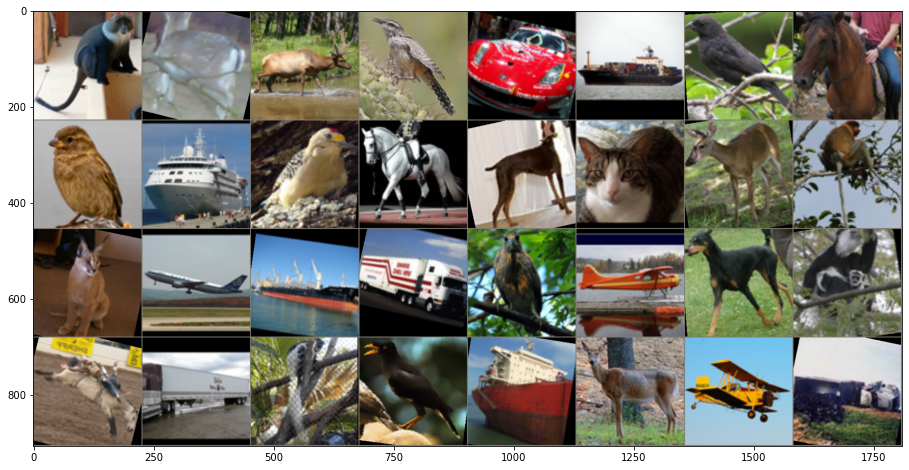

tensor([7, 4, 4, 1, 2, 8, 1, 6, 1, 8, 1, 6, 5, 3, 4, 7, 3, 0, 8, 9, 1, 0, 5, 7,
        6, 9, 7, 1, 8, 4, 0, 9])


In [6]:
# Function to show images
def show_img(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.507, 0.487, 0.441])
    std = np.array([0.267, 0.256, 0.276])
    img = mean + img * std # Unnormalize
    plt.figure(figsize=(16, 8))
    plt.imshow((255 * img).astype(int))  # Convert from tensor image
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
show_img(make_grid(images[:32]))
print(labels[:32])

In [7]:
class PatchClassPositionEmbeddings(nn.Module):
    def __init__(self, image_size=224, patch_size=16, embed_dim=768, in_channels=3):
        super().__init__()
        num_patches = (image_size // patch_size) ** 2
        self.conv = nn.Conv2d(in_channels, embed_dim, patch_size, stride=patch_size)
        self.cls_token_emb = nn.Parameter(torch.randn(1, 1, embed_dim), requires_grad=True)
        self.positional_encodings = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=True)

    def forward(self, x):
        # Patch Embeddings
        x = self.conv(x)
        batch_size, channel, height, width = x.shape
        x = x.flatten(2).transpose(1, 2)  # Simplified reshaping below
        # x = x.permute(2, 3, 0, 1)
        # x = x.view(height * width, batch_size, channel)

        # Class Token Embedding
        cls_token_emb = self.cls_token_emb.expand(batch_size, -1, -1)
        x = torch.cat([cls_token_emb, x], dim=1)

        # Position Embedding
        x += self.positional_encodings[:, :x.size(1)]
        return x

class MLP(nn.Module):
    def __init__(self, embed_dim, mlp_dim, dropout = 0.):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.mlp(x)

class TransformerEncoder(nn.Module):
    def __init__(self, num_heads=12, embed_dim=768, mlp_dim=3072, dropout=0.1, attention_dropout=0.1):
        super().__init__()
        self.ln_1 = nn.LayerNorm(embed_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=attention_dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.ln_2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim, dropout)

    def forward(self, x):
        # Attention and Residual Connection
        out1 = self.ln_1(x)
        out1, _ = self.self_attention(out1, out1, out1)
        x = out1 + x

        # MLP and Residual Connection
        out2 = self.ln_2(x)
        out2 = self.mlp(out2)
        x = out2 + x
        return x

class MLPHead(nn.Module):
    def __init__(self, embed_dim=768, representation_size=3072, num_classes=10):
        super().__init__()
        self.mlp_head = nn.Sequential(
            nn.Linear(embed_dim, representation_size),
            nn.Tanh(),
            nn.Linear(representation_size, num_classes),
        )

    def forward(self, x):
        return self.mlp_head(x)

class VisionTransformer(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channel=3, num_heads=3, depth=3, embed_dim=768, mlp_dim=2048, num_classes=10, dropout=0.1, attention_dropout=0.1):
        super().__init__()
        self.patch_class_position_embedding = PatchClassPositionEmbeddings(image_size, patch_size, embed_dim, in_channel)
        self.transformer_layers = nn.ModuleList([TransformerEncoder(num_heads, embed_dim, mlp_dim, dropout, attention_dropout) for _ in range(depth)])
        self.ln = nn.LayerNorm(embed_dim)
        self.classification = MLPHead(embed_dim, mlp_dim, num_classes)

    def forward(self, x):
        x = self.patch_class_position_embedding(x)
        for layer in self.transformer_layers:
            x = layer(x)
        x = self.ln(x[:, 0])
        x = self.classification(x)
        return x


In [8]:
model = VisionTransformer().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.8, nesterov=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=157)
summary(model, (3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
PatchClassPositionEmbeddings-2             [-1, 197, 768]               0
         LayerNorm-3             [-1, 197, 768]           1,536
MultiheadAttention-4  [[-1, 197, 768], [-1, 197, 197]]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2048]       1,574,912
              GELU-7            [-1, 197, 2048]               0
           Dropout-8            [-1, 197, 2048]               0
            Linear-9             [-1, 197, 768]       1,573,632
          Dropout-10             [-1, 197, 768]               0
              MLP-11             [-1, 197, 768]               0
TransformerEncoder-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
MultiheadAttention-14

In [9]:
epochs = 100

# Lists to track metrics over epochs
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_accuracy = 0

    # Training phase
    model.train()
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_train_accuracy += acc.item() / len(train_loader)
        epoch_train_loss += loss.item() / len(train_loader)

    if epoch % 3 == 0:
        scheduler.step()

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation phase
    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc.item() / len(valid_loader)
            epoch_val_loss += val_loss.item() / len(valid_loader)

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch: {epoch+1} - Train Loss: {epoch_train_loss:.4f} - Train Accuracy: {epoch_train_accuracy:.4f} - Val Loss: {epoch_val_loss:.4f} - Val Accuracy: {epoch_val_accuracy:.4f}")


# Show final test accuracy
model.eval()
with torch.no_grad():
    epoch_test_accuracy = 0
    epoch_test_loss = 0
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)

        test_output = model(data)
        test_loss = criterion(test_output, label)

        acc = (test_output.argmax(dim=1) == label).float().mean()
        epoch_test_accuracy += acc / len(test_loader)
        epoch_test_loss += test_loss / len(test_loader)
print(f"Test loss : {epoch_test_loss:.4f} - Test Accuracy: {epoch_test_accuracy:.4f}")

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 1 - Train Loss: 1.9599 - Train Accuracy: 0.2664 - Val Loss: 1.6540 - Val Accuracy: 0.3574


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 2 - Train Loss: 1.6740 - Train Accuracy: 0.3566 - Val Loss: 1.5812 - Val Accuracy: 0.3999


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 3 - Train Loss: 1.5921 - Train Accuracy: 0.3901 - Val Loss: 1.4979 - Val Accuracy: 0.4170


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 4 - Train Loss: 1.5119 - Train Accuracy: 0.4256 - Val Loss: 1.5124 - Val Accuracy: 0.4253


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 5 - Train Loss: 1.4561 - Train Accuracy: 0.4506 - Val Loss: 1.5534 - Val Accuracy: 0.4141


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 6 - Train Loss: 1.4155 - Train Accuracy: 0.4637 - Val Loss: 1.4726 - Val Accuracy: 0.4565


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 7 - Train Loss: 1.3833 - Train Accuracy: 0.4829 - Val Loss: 1.3857 - Val Accuracy: 0.4722


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 8 - Train Loss: 1.3456 - Train Accuracy: 0.5005 - Val Loss: 1.3585 - Val Accuracy: 0.4873


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 9 - Train Loss: 1.3033 - Train Accuracy: 0.5116 - Val Loss: 1.4016 - Val Accuracy: 0.4766


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 10 - Train Loss: 1.2986 - Train Accuracy: 0.5159 - Val Loss: 1.4061 - Val Accuracy: 0.4795


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 11 - Train Loss: 1.2710 - Train Accuracy: 0.5186 - Val Loss: 1.4187 - Val Accuracy: 0.4897


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 12 - Train Loss: 1.2428 - Train Accuracy: 0.5354 - Val Loss: 1.2789 - Val Accuracy: 0.5103


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 13 - Train Loss: 1.2174 - Train Accuracy: 0.5421 - Val Loss: 1.3189 - Val Accuracy: 0.5063


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 14 - Train Loss: 1.2110 - Train Accuracy: 0.5475 - Val Loss: 1.3671 - Val Accuracy: 0.5059


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 15 - Train Loss: 1.1980 - Train Accuracy: 0.5515 - Val Loss: 1.3837 - Val Accuracy: 0.4902


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 16 - Train Loss: 1.1747 - Train Accuracy: 0.5645 - Val Loss: 1.2622 - Val Accuracy: 0.5229


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 17 - Train Loss: 1.1428 - Train Accuracy: 0.5800 - Val Loss: 1.3640 - Val Accuracy: 0.5000


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 18 - Train Loss: 1.1537 - Train Accuracy: 0.5710 - Val Loss: 1.2927 - Val Accuracy: 0.5244


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 19 - Train Loss: 1.1409 - Train Accuracy: 0.5785 - Val Loss: 1.2945 - Val Accuracy: 0.5137


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 20 - Train Loss: 1.1170 - Train Accuracy: 0.5791 - Val Loss: 1.3911 - Val Accuracy: 0.5029


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 21 - Train Loss: 1.1162 - Train Accuracy: 0.5880 - Val Loss: 1.2851 - Val Accuracy: 0.5264


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 22 - Train Loss: 1.1007 - Train Accuracy: 0.5946 - Val Loss: 1.3032 - Val Accuracy: 0.5234


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 23 - Train Loss: 1.0739 - Train Accuracy: 0.6049 - Val Loss: 1.3367 - Val Accuracy: 0.5073


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 24 - Train Loss: 1.0521 - Train Accuracy: 0.6149 - Val Loss: 1.3107 - Val Accuracy: 0.5215


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 25 - Train Loss: 1.0533 - Train Accuracy: 0.6112 - Val Loss: 1.3391 - Val Accuracy: 0.5293


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 26 - Train Loss: 1.0326 - Train Accuracy: 0.6252 - Val Loss: 1.3498 - Val Accuracy: 0.5210


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 27 - Train Loss: 1.0282 - Train Accuracy: 0.6152 - Val Loss: 1.2739 - Val Accuracy: 0.5479


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 28 - Train Loss: 1.0219 - Train Accuracy: 0.6247 - Val Loss: 1.3076 - Val Accuracy: 0.5381


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 29 - Train Loss: 1.0012 - Train Accuracy: 0.6332 - Val Loss: 1.2743 - Val Accuracy: 0.5464


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 30 - Train Loss: 0.9814 - Train Accuracy: 0.6412 - Val Loss: 1.2862 - Val Accuracy: 0.5322


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 31 - Train Loss: 0.9738 - Train Accuracy: 0.6379 - Val Loss: 1.4442 - Val Accuracy: 0.5063


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 32 - Train Loss: 0.9815 - Train Accuracy: 0.6381 - Val Loss: 1.3058 - Val Accuracy: 0.5303


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 33 - Train Loss: 0.9512 - Train Accuracy: 0.6495 - Val Loss: 1.3743 - Val Accuracy: 0.5234


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 34 - Train Loss: 0.9468 - Train Accuracy: 0.6500 - Val Loss: 1.2931 - Val Accuracy: 0.5493


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 35 - Train Loss: 0.9424 - Train Accuracy: 0.6576 - Val Loss: 1.2803 - Val Accuracy: 0.5415


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 36 - Train Loss: 0.9284 - Train Accuracy: 0.6616 - Val Loss: 1.2869 - Val Accuracy: 0.5425


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch: 37 - Train Loss: 0.9270 - Train Accuracy: 0.6567 - Val Loss: 1.3296 - Val Accuracy: 0.5449


  0%|          | 0/125 [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid 21586) is killed by signal: Killed. 

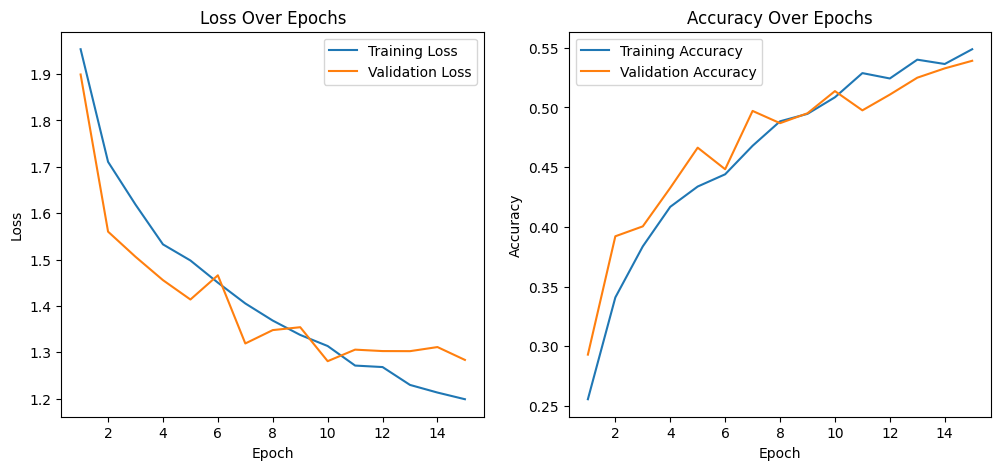

In [ ]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

In [ ]:
torch.save(model.state_dict(), './vit_model_cifar10.pt') # save the model parameters
model.load_state_dict(torch.load('./vit_model_cifar10.pt')) # load the saved parameters
